In [2]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import joblib

import xgboost as xgb
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version xgboost: {xgb.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.18.0
- Version scikit-learn: 1.7.2
- Version xgboost: 3.1.2
- Version pandas: 2.3.3
- Version numpy: 2.2.6


In [3]:
try:
    df = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/accesos_biblioteca.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'accesos_biblioteca.csv'.")
    exit(1)

Dataset cargado desde 'Datasets/accesos_biblioteca.csv'


In [4]:
print("Dataset original - Columnas iniciales:")
print(f"Columnas: {list(df.columns)}")
print(f"Forma del dataset: {df.shape}")
print("\nPrimeras 3 filas:")
print(df.head(3))

Dataset original - Columnas iniciales:
Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Semestre', 'Accesos', 'Vacaciones?']
Forma del dataset: (511, 7)

Primeras 3 filas:
        Fecha  Día  Mes   Año  Semestre  Accesos  Vacaciones?
0  2023-12-14   14   12  2023         2      953            0
1  2023-12-15   15   12  2023         2      549            0
2  2023-12-16   16   12  2023         2       71            0


In [5]:
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

In [6]:
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)
    
def obtener_semana_semestre(fecha):
    mes = fecha.month
    dia = fecha.day
    if 3 <= mes <= 7:
        inicio_semestre = datetime(fecha.year, 3, 1)
    elif 8 <= mes <= 12:
        inicio_semestre = datetime(fecha.year, 8, 1)
    else:
        return 0  # Fuera de semestre
    delta = fecha - inicio_semestre
    semana_semestre = delta.days // 7 + 1
    return semana_semestre

In [7]:
for col in ['Accesos']:
    df[col] = df[col].fillna(0).astype(int)

df = df[
    pd.to_datetime(df['Fecha']).dt.weekday != 6
].reset_index(drop=True)

df = agregar_medias_moviles(df, 'Accesos', [7, 14, 30])
df = agregar_variables_ciclicas(df, 'Mes', 'Fecha')
df = agregar_ewma(df, 'Accesos', [7, 14, 30])

df['Semestre'] = df['Mes'].apply(obtener_semestre)
df['Semana_Semestre'] = pd.to_datetime(df['Fecha']).apply(obtener_semana_semestre)

df['Fecha'] = pd.to_datetime(df['Fecha'])

df = agregar_lags(df, 'Accesos', [7, 14, 21])

df = df.dropna().reset_index(drop=True)
df.tail(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,...,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre,lag_7,lag_14,lag_21
412,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,...,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866,9,2544.0,4145.0,3923.0
413,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,...,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520,10,1356.0,1592.0,4248.0
414,2025-05-05,5,5,2025,1,2750,0,1028.428571,1531.857143,2438.466667,...,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938,10,526.0,0.0,3976.0
415,2025-05-06,6,5,2025,1,1866,0,1346.142857,1728.285714,2417.700000,...,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296,10,2400.0,0.0,3140.0
416,2025-05-07,7,5,2025,1,2254,0,1269.857143,1861.571429,2362.766667,...,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697,10,2568.0,3841.0,852.0


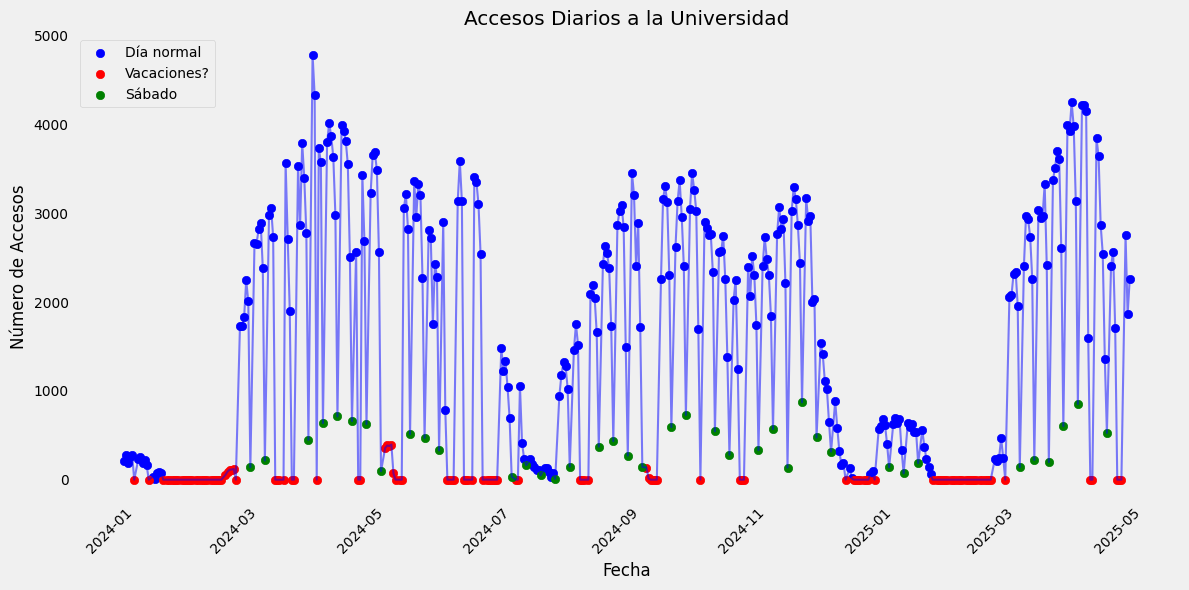

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday != 5)
plt.scatter(df['Fecha'][no_vac_no_sab], df['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones
vac = (df['Vacaciones?'] == 1)
plt.scatter(df['Fecha'][vac], df['Accesos'][vac], color='r', label='Vacaciones?')

# Puntos de sábados
sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday == 5)
plt.scatter(df['Fecha'][sab], df['Accesos'][sab], color='g', label='Sábado')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

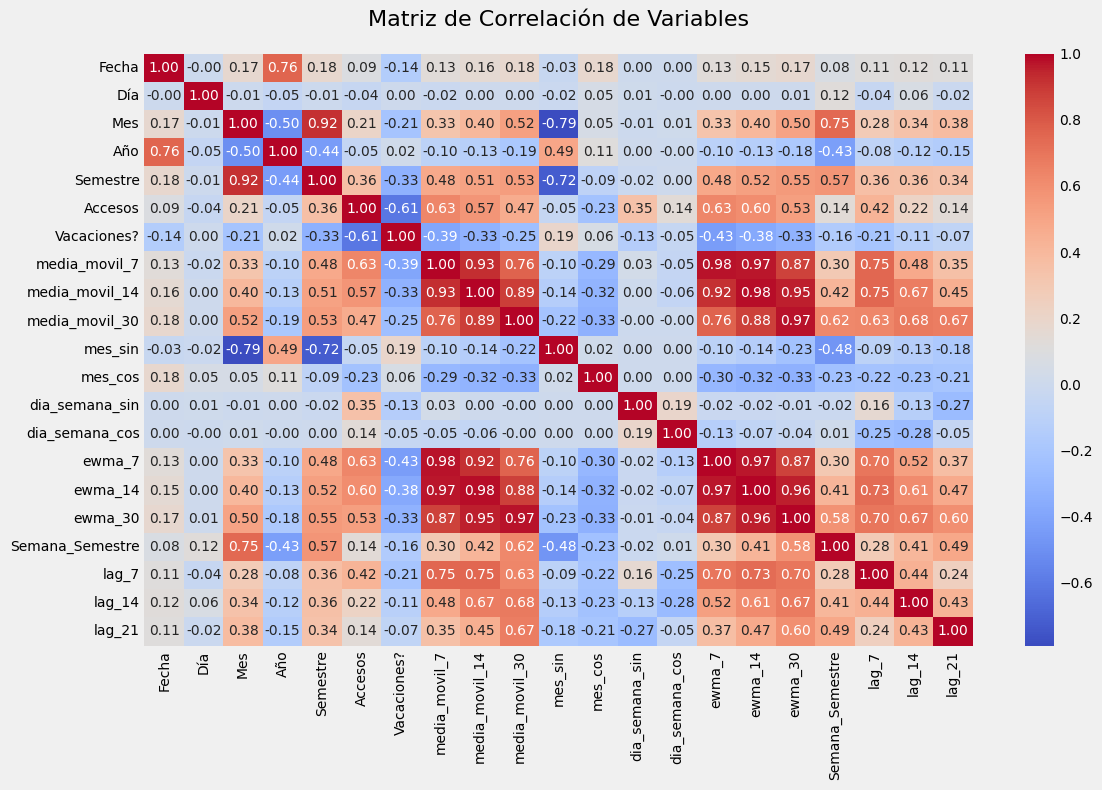

In [9]:
# Matriz de coorrelación
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación de Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [10]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 333
Datos de prueba: 84


In [13]:
os.makedirs('Archivos Auxiliares', exist_ok=True)
if "modelo_XGBoost.pkl" not in os.listdir('Archivos Auxiliares'):
    print("Entrenando el modelo XGBoost")
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train, y_train)

    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 300, 500, 700],
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [3, 5, 8, 15],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0.5, 1, 2] 
    }

    grid_search = GridSearchCV(
        xgb.XGBRegressor(random_state=42),
        param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f'Mejores parámetros: {grid_search.best_params_}')

    best_params = grid_search.best_params_
    model = xgb.XGBRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares/modelo_XGBoost.pkl')
    print("Modelo guardado como 'Archivos Auxiliares/modelo_XGBoost.pkl'")
else:
    model = joblib.load('Archivos Auxiliares/modelo_XGBoost.pkl')
    print("Modelo cargado desde 'Archivos Auxiliares/modelo_XGBoost.pkl'")

Entrenando el modelo XGBoost
Mejores parámetros: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 500, 'reg_alpha': 1, 'reg_lambda': 2, 'subsample': 1}
Modelo guardado como 'Archivos Auxiliares/modelo_XGBoost.pkl'


In [14]:
# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
print("\n Importancia de las características \n")
for i in range(X.shape[1]):
    print(f"{i + 1:2d}. {X.columns[indices[i]]}: {importancias[indices[i]]:.4f}")


 Importancia de las características 

 1. ewma_7: 0.3441
 2. Vacaciones?: 0.3161
 3. dia_semana_sin: 0.1447
 4. Semana_Semestre: 0.0942
 5. media_movil_14: 0.0256
 6. ewma_14: 0.0215
 7. mes_sin: 0.0113
 8. media_movil_30: 0.0095
 9. Mes: 0.0084
10. mes_cos: 0.0058
11. lag_21: 0.0034
12. media_movil_7: 0.0030
13. ewma_30: 0.0026
14. lag_7: 0.0023
15. Día: 0.0023
16. dia_semana_cos: 0.0019
17. Año: 0.0016
18. lag_14: 0.0016
19. Semestre: 0.0000


In [15]:
# Eliminar características con importancia menor a 0.01
umbral_importancia = 0.01
caracteristicas_seleccionadas = X.columns[importancias >= umbral_importancia]
X_train = X_train[caracteristicas_seleccionadas]
X_test = X_test[caracteristicas_seleccionadas]

#Reentrenar el modelo con las características seleccionadas
model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [16]:
predicted = model.predict(X_test)
predicted = np.maximum(predicted, 0)

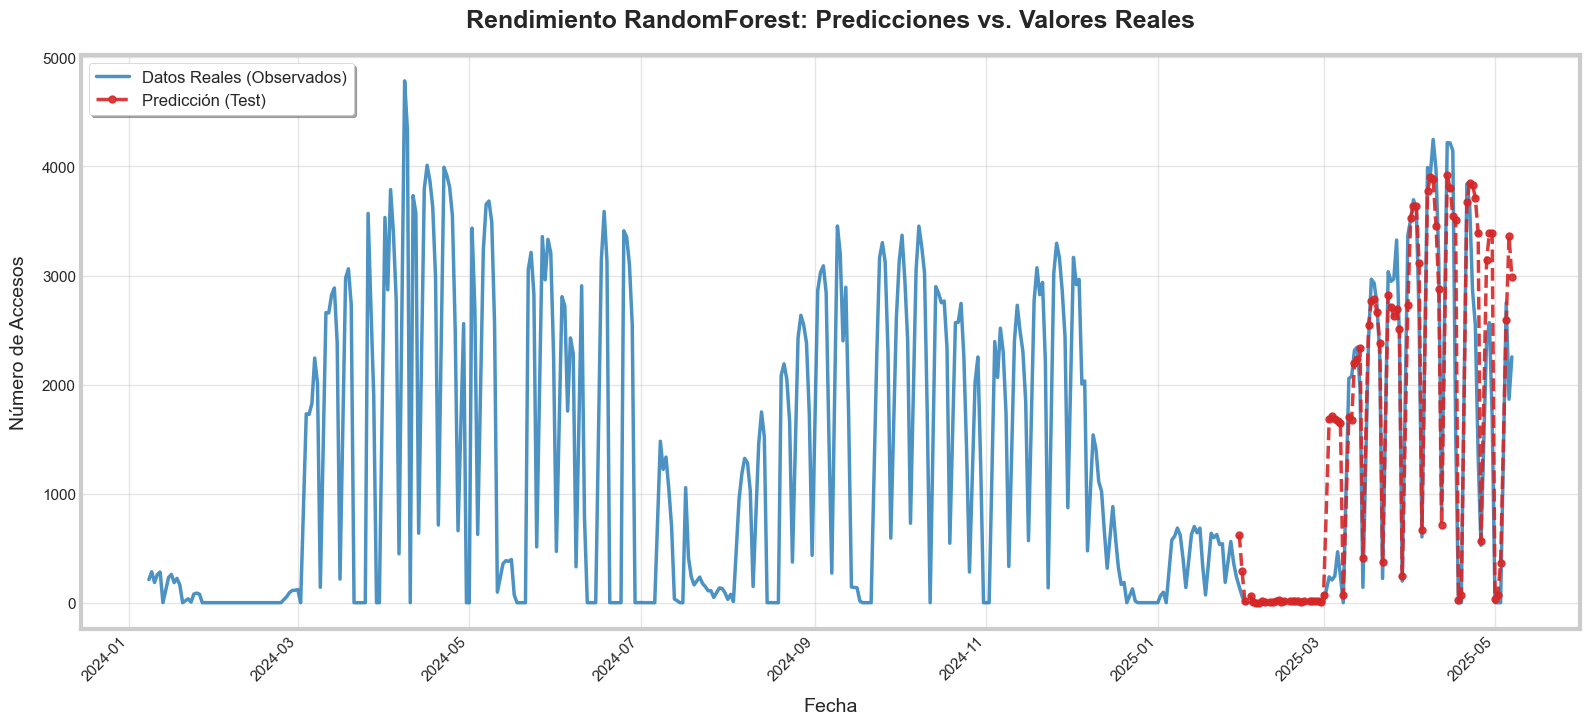


Métricas de Rendimiento del Modelo
R² (Coeficiente de Determinación): 0.84
Error Cuadrático Medio (MSE): 361953.66
Error Cuadrático Medio Raíz (RMSE): 601.63
Error Absoluto Medio (MAE): 345.20


In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8)) 

plt.plot(
    df['Fecha'],
    df['Accesos'],
    label='Datos Reales (Observados)',
    color='#1f77b4',
    linewidth=2.5,
    alpha=0.8
)

plt.plot(
    df['Fecha'].loc[X_test.index],
    predicted,
    label='Predicción (Test)',
    color='#d62728',
    linestyle='--',
    linewidth=2.5,
    marker='o',
    markersize=5,
    alpha=0.9
)

plt.xlabel('Fecha', fontsize=14, labelpad=10)
plt.ylabel('Número de Accesos', fontsize=14, labelpad=10)
plt.title(
    'Rendimiento RandomForest: Predicciones vs. Valores Reales',
    fontsize=18,
    fontweight='bold',
    pad=20
)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
plt.grid(True, axis='both', linestyle='-', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print("\nMétricas de Rendimiento del Modelo")
print(f"R² (Coeficiente de Determinación): {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")